In [1]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import jax.numpy as jnp
import os
from perch.perch_ph import PH
from perch.perch_structures import Structures
import matplotlib.pyplot as plt

In [2]:
rname = 'phangs'
ddir = '/Users/toneill/Perch/phangs/'
perchdir = f'/Users/toneill/Perch/output/'
odir = f'{perchdir}{rname}/'

if not os.path.isdir(perchdir):
    os.mkdir(perchdir)
if not os.path.isdir(odir):
    os.mkdir(odir)
os.chdir(odir)

In [4]:
img_hdu = fits.open(ddir+'ngc0628_miri_f770w_anchored.fits')

wcs_img = WCS(img_hdu[0].header)#[375:875,375:875,375:875]
img = img_hdu[0].data#[375:875,375:875,375:875]

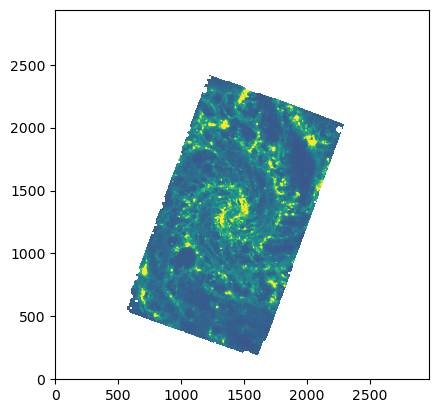

In [6]:
plt.imshow(img,origin='lower',vmax=10)

## STEP 1: compute persistent homology candidates

In [7]:
hom = PH.compute_hom(img,verbose=True,wcs=wcs_img)
hom.export_generators(f'{rname}.txt',odir=odir)

Computing PH... 

\n PH Computation Complete! 
 1.2s elapsed


## STEP 2: filter candidates by some threshold

In [43]:
hom = PH.load_from(f'{rname}.txt',odir=odir,data=img)

In [44]:
dim_use = 1
hi = hom.filter(dimension=dim_use)

all_life = hi[:,1]-hi[:,2]
#rel_life = all_life / hi[:,1]

all_thresh = 0.5
fname = f'{rname}_h{dim_use}_filt_life{all_thresh}'

Text(0, 0.5, 'Lifetime')

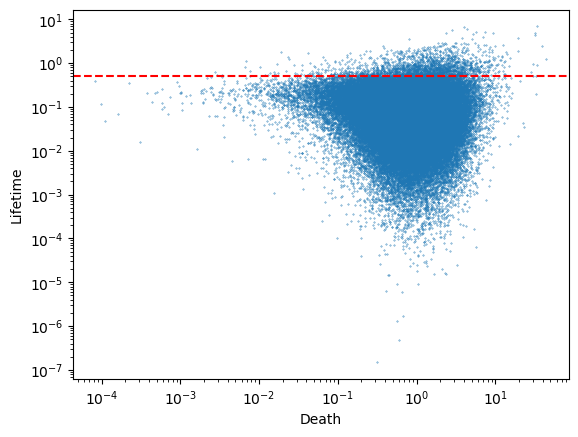

In [45]:
plt.figure()
plt.scatter(hi[:,2],all_life,s=0.1)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.axhline(y=all_thresh,c='r',ls='--')
plt.xlabel('Death')
plt.ylabel('Lifetime')

In [46]:
hi_use = np.where((all_life >=all_thresh))
hi_filt = hi[hi_use]
hi_save = np.hstack((hi_filt, np.array(hi_use).reshape(-1,1)))

np.savetxt(f'{odir}{fname}.txt', hi_save)

## STEP 3: segment original image

In [47]:
inds_dir = f'{odir}inds/h{dim_use}/'
if not os.path.isdir(f'{odir}inds/'):
    os.mkdir(f'{odir}inds/')
if not os.path.isdir(inds_dir):
    os.mkdir(inds_dir)

In [48]:
hom = PH.load_from(f'{fname}.txt',odir=odir,data=img)
hi_struc = hom.generators
strucs = Structures(structures=hi_struc, img_shape=np.shape(img), wcs=wcs_img, inds_dir=inds_dir)

In [49]:
img_jnp = jnp.array(img)
strucs.compute_segment(img_jnp)
strucs.compute_hierarchy(clobber=True)
strucs.export_struc_map(fname=fname, odir=odir)

100%|██████████| 2361/2361 [00:00<00:00, 8686.48structures/s]


Text(0.5, 1.0, 'Level in hierarchy')

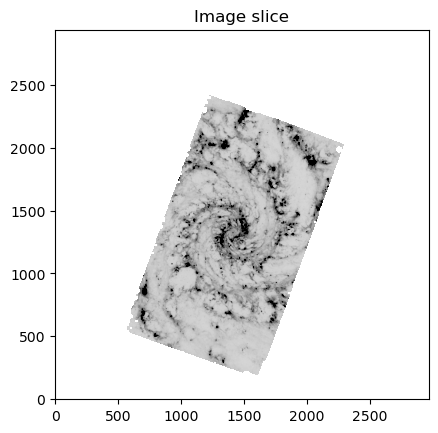

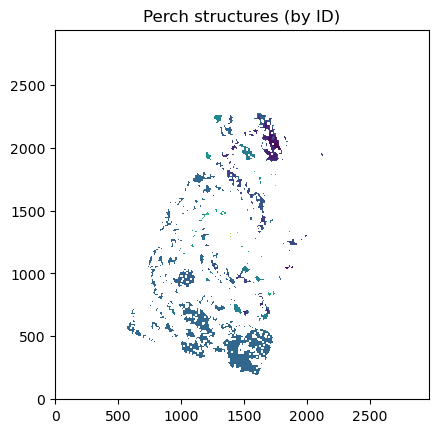

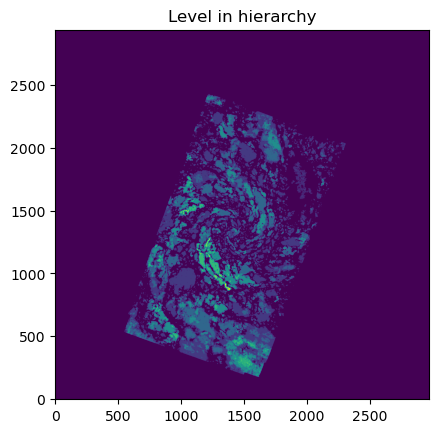

In [55]:
plt.figure()
plt.imshow(img,cmap='Greys',origin='lower',vmax=10)
plt.title('Image slice')

plt.figure()
plt.imshow(strucs.struc_map,cmap='viridis',alpha=1,origin='lower')
plt.title('Perch structures (by ID)')

plt.figure()
plt.imshow(strucs.level_map,cmap='viridis',alpha=1,origin='lower')
plt.title('Level in hierarchy')

(array([ 9.,  0.,  0.,  0.,  0., 17.,  0.,  0., 14.,  0., 29.,  0., 20.,
        30., 33., 29., 34., 32., 34., 60., 53., 49., 70., 58., 61., 67.,
        86., 70., 97., 86., 71., 74., 80., 85., 87., 72., 66., 56., 47.,
        58., 50., 52., 55., 36., 32., 40., 28., 26., 32., 25., 28., 16.,
        30., 18., 23., 14., 14., 11., 10.,  7.,  7.,  5.,  4.,  7.,  4.,
        11.,  5.,  4.,  4.,  1.,  2.,  3.,  4.,  2.,  2.,  1.,  4.,  2.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.0567527 , 0.11350539, 0.17025809, 0.22701078,
        0.28376348, 0.34051617, 0.39726887, 0.45402156, 0.51077426,
        0.56752695, 0.62427965, 0.68103234, 0.73778504, 0.79453773,
        0.85129043, 0.90804313, 0.96479582, 1.02154852, 1.07830121,
        1.13505391, 1.1918066 , 1.2485593 , 1.30531199, 1.36206469,
        1.41881738, 1.47557008, 1.53232277, 1.58907547, 1.64582816,
        1.70258086, 1.7593

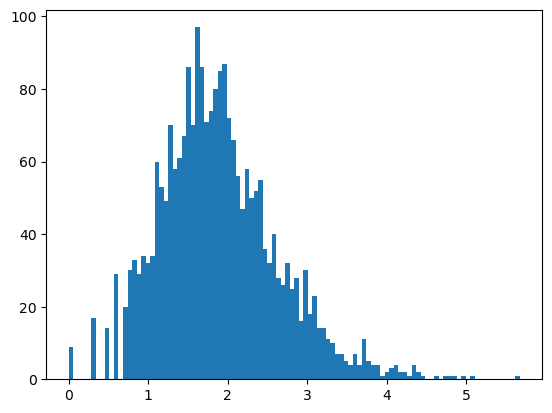

In [60]:
plt.figure()
plt.hist(np.log10(strucs.npix),bins=100)